In [1]:
# Imports
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import transforms
import sys
from __future__ import division

### 1. (30pts) Define functions

In [2]:
# One hot Encoding the categorical output values to binary by adding 1's for that index and 0's otherwise
def oneHotEncode(y):
    enc = pd.get_dummies(y['y'])
    return np.matrix(enc)

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# works with scalar, arrays and matrix as well
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    return 1./(1+np.exp(-z))

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# works with scalar, arrays and matrix as well
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Get the loss of for the training example
def get_cost(Y, Yhat, lamda, Wl):
    m= Y.shape[1]
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss) + ((lamda/(2*m)) * np.sum(np.square(Wl)))
    cost = np.squeeze(cost)
    return cost

# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, layerCount, activationFuncs):
    for l in range(1, layerCount+1):
        Zl =  'Z' + str(l)
        Al =  'A' + str(l)
        Wl =  'W' + str(l)
        Al1 = 'A' + str(l-1)
        bl =  'b' + str(l)
        cache[Zl] = np.dot(cache[Wl], cache[Al1]) + cache[bl]
        activationFunc = activationFuncs[l] + '(cache[Zl])'
        cache[Al] = eval(activationFunc)
    return cache

# Backward Propagation function to calculate the gradients
def back_propagate(cache, layerCount, deactivationFuncs):
    gradients = {}
    m = cache['A0'].shape[1]
    for l in xrange(layerCount, 0, -1):
        if(l==layerCount): # is last layer
            dZl = cache['A' + str(l)] - cache['A' + str(l+1)]    
        else:
            Zl = 'Z'+ str(l)
            dZl1 = 'dZ'+str(l+1)
            deacFunc = deactivationFuncs[l] + '(cache[Zl])'
            actv_prime = eval(deacFunc)
            term1 = cache['W'+str(l+1)].T
            term2 = gradients[dZl1]
            product = np.dot( term1, term2)
            dZl = np.multiply(product, actv_prime) 
        gradients['dZ' + str(l)] = dZl
        Al1 = cache['A' + str(l-1)]
#         print('--dZ'+str(l))
#         print(dZl.shape)
#         print('A'+str(l-1))
#         print( Al1.shape)
        dWl = (1./m) * np.dot(dZl, Al1.T)
        dbl = (1./m) * np.sum(dZl, axis=1)
#         print('dW' +str(l))
#         print(dWl.shape)
#         print('db' +str(l))
#         print(dbl.shape)
        gradients['dW' + str(l)] = dWl
        gradients['db' + str(l)] = dbl
    return gradients  


def gradientDescent(X, Y, YOrg, alpha, iters, hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, lamda, Xtest, Ytest):  
    
    cache = initialize_parameters(hiddenLayers, layerSizes,activationFuncs )
    cache['A0'] = X
    ykey = 'A' + str(hiddenLayers+1)
    cache[ykey] = Y
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    cost_history = []
    maxTestAcc = -sys.maxsize -1
    for i in range(iters):
        # Call Forward propagation to calculate yHat
        cache = forward_propagate(cache, hiddenLayers, activationFuncs)
        old_cost = new_cost
        Afinal = cache['A'+str(hiddenLayers)]
        new_cost = get_cost(Y, cache['A'+str(hiddenLayers)], lamda, cache['W'+str(hiddenLayers)]) # Regularization
        gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)
        for l in range(1,hiddenLayers+1):
            Wl = cache['W'+str(l)]
            gradients['dW'+str(l)] = gradients['dW'+str(l)] + (lamda/m) * Wl  # Regularization
            Wl = Wl - alpha * gradients['dW'+str(l)]
            cache['W'+str(l)] = Wl
            bl = cache['b'+str(l)]
            bl = bl - alpha * gradients['db'+str(l)]
            cache['b'+str(l)] = bl
        if(abs(old_cost - new_cost) < 0.00000000001):
            print("breaking" + str(old_cost) + str(new_cost))
            break;
        if(i%10 ==0):
            testcache = cache.copy()
            testcache['A0'] = Xtest
            ykey = 'A' + str(hiddenLayers+1)
            cache2 = forward_propagate(testcache, hiddenLayers, activationFuncs)
            ATestfinal = softmax(cache2['A'+str(hiddenLayers)])
            acc = get_accuracy(Ytest, ATestfinal)
            maxTestAcc = max(maxTestAcc, acc)
            print ("cost : " + str(new_cost) + " Test Accuracy : " + str(acc) + " Iteration: " + str(i))
        cost_history.append(new_cost)
    Afinal = softmax(Afinal) # Apply softmax to get the actual labels
    cache['A'+str(hiddenLayers)] = Afinal
    accuracy = get_accuracy(YOrg, Afinal)
    print("Maximum test accuracy is " + str(maxTestAcc))
    return cache, cost_history, new_cost, accuracy

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def plotCostHistory(cost_history, alpha, i):
     line = plt.plot(cost_history, label=alpha)
     plt.ylabel('Cost');
     plt.ylim( (0, 4) )
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations for different learning rates')
     plt.legend()
        
def get_accuracy(Y, Ypred):
    Y = np.matrix(Y)
    numcorrect = 0
    for (x,y) in zip(Ypred,Y):
        if(x[0]==y[0]):
            numcorrect+=1
    accuracy=numcorrect*100.0/len(Y)
    return accuracy

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('exam1_train.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_train = data_train.drop('Unnamed: 0',axis=1)
m = df_train.shape[0]

y_train = pd.DataFrame(df_train['y'])
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train).T
y_train_mat = oneHotEncode(y_train).T

     y
202  4


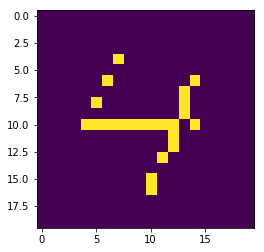

In [4]:
# Reading the test data
data_test = pd.read_csv('exam1_test.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_test = data_test.drop('Unnamed: 0',axis=1)

y_test = pd.DataFrame(df_test['y'])
X_test = df_test.drop(['y'], axis=1)

X_test_mat = np.matrix(X_test).T
y_test_mat = oneHotEncode(y_test).T

# Plot the selected pixel
num = 202
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. (10pts) Initialize parameters

In [5]:
# Initialize weights // TODO - change the initialization method

np.random.seed(1) # Setting random seed to 1
def initialize_parameters(hiddenLayers, layerSizes, activationFuncs):
    cache = {}
    for l in range(1,hiddenLayers+1):
        #print(l)
        Wl = 'W' + str(l)
        bl = 'b' + str(l)
        #print(layerSizes[l])
        #print(layerSizes[l-1])
        print('activation is ' + str(activationFuncs[l]) + ' for layer ' + str(l))
        if(activationFuncs[l]=='sigmoid'):
            print('activation is sigmoid for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * np.sqrt(2./layerSizes[l-1])
            cache[bl] =  np.zeros((layerSizes[l],1))
        elif(activationFuncs[l]=='relu'):
            print('activation is relu for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * (2./np.sqrt(layerSizes[l-1]))
            cache[bl] =  np.zeros((layerSizes[l],1))
        else:
            print('activation is random for layer ' + str(l))
            cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * 0.01 ## Random
            cache[bl] =  np.zeros((layerSizes[l],1))
        l=l+1
    #print(cache)
    return cache

### 4. (30pts) Deep Neural Network model with more than 2 hidden layers

In [6]:
# Defining Hyperparameters
hiddenLayers = 3
layerSizes = [400, 100, 40, 10] # As specified in assignment requirements, can have as many hidden layers
print(" Number of hidden layers including output layer are - " + str(hiddenLayers))
activationFuncs = ['', 'relu', 'relu', 'sigmoid']
deactivationFuncs = ['', 'relu_prime', 'relu_prime', 'sigmoid_prime']

 Number of hidden layers including output layer are - 3


In [7]:
# cache = initialize_parameters(hiddenLayers, layerSizes, activationFuncs)
# print(cache['W1'].shape)
# # print(cache['W2'].shape)
# # print(cache['W3'].shape)
# # print(cache['b1'].shape)
# # print(cache['b2'].shape)
# # print(cache['b3'].shape)
# cache['A0'] = X_train_mat
# ykey = 'A' + str(len(layerSizes))
# cache[ykey] = y_train_mat
# cache = forward_propagate(cache, hiddenLayers, ['', 'apply_sigmoid', 'apply_sigmoid','apply_sigmoid'])
# # print(cache['A1'])
# # print(cache['A2'])
# # print(cache['A3'])
# # print(cache['Z2'])

In [8]:
# gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)

### 5. (10pts) Predictions

### 6. (20pts) Optimization

In [ ]:
# Optimization function to check cost propagartion for different learning rates
def optimize():
    lamdas = [14.0]
    alpha = [0.3,0.4,0.5,0.6]
    i=0
    scores = pd.DataFrame(columns=['alpha','cache','accuracy', 'lamda'])
    print('*****************Training Data*********************')
    for l in lamdas:
        for a in alpha:
            cache, cost_history, new_cost, acc = gradientDescent(X_train_mat, y_train_mat, y_train, a, 15000, 
                                                hiddenLayers, layerSizes, activationFuncs, deactivationFuncs, l, X_test_mat, y_test)
            scores.loc[i] = pd.Series({'alpha':a, 'cache': cache, 'accuracy':acc, 'lamda':l})
            print("Cost with " + "Alpha " + str(a) + " and lambda " + str(l) + " is " + str(new_cost) + " & " + "Accuracy is " + str(acc) + " %")
            plotCostHistory(cost_history, a, i)
            i+=1
        least_cost_comb = scores['accuracy'].idxmax()
        alph = scores.iloc[[least_cost_comb]]['alpha'][least_cost_comb]
        cache = scores.iloc[[least_cost_comb]]['cache'][least_cost_comb]
        plt.show()
        print('Best alpha is ' + str(alph))
    return cache, alph,scores

In [ ]:
# Get the best combination of weights and alpha
cache, alph,scores = optimize()

*****************Training Data*********************
activation is relu for layer 1
activation is relu for layer 1
activation is relu for layer 2
activation is relu for layer 2
activation is sigmoid for layer 3
activation is sigmoid for layer 3
cost : 8.32843109401 Test Accuracy : 10.7333333333 Iteration: 0
cost : 2.98364050691 Test Accuracy : 51.5333333333 Iteration: 10
cost : 1.88824945209 Test Accuracy : 72.2 Iteration: 20
cost : 1.95258757419 Test Accuracy : 71.1333333333 Iteration: 30
cost : 1.20393569582 Test Accuracy : 80.6666666667 Iteration: 40
cost : 0.995012783609 Test Accuracy : 84.0666666667 Iteration: 50
cost : 0.935227227517 Test Accuracy : 84.0 Iteration: 60
cost : 0.835637293229 Test Accuracy : 84.5333333333 Iteration: 70
cost : 0.722066096967 Test Accuracy : 87.6666666667 Iteration: 80
cost : 0.690261785726 Test Accuracy : 87.7333333333 Iteration: 90
cost : 0.664105014915 Test Accuracy : 88.9333333333 Iteration: 100
cost : 0.605895544986 Test Accuracy : 90.0666666667 I

cost : 0.247723050792 Test Accuracy : 93.6666666667 Iteration: 1250
cost : 0.249470469471 Test Accuracy : 93.7333333333 Iteration: 1260
cost : 0.254035887123 Test Accuracy : 93.8 Iteration: 1270
cost : 0.254802343815 Test Accuracy : 93.8 Iteration: 1280
cost : 0.247211980123 Test Accuracy : 93.6666666667 Iteration: 1290
cost : 0.245957814459 Test Accuracy : 93.5333333333 Iteration: 1300
cost : 0.246791474364 Test Accuracy : 93.3333333333 Iteration: 1310
cost : 0.24941037591 Test Accuracy : 93.1333333333 Iteration: 1320
cost : 0.253630113167 Test Accuracy : 93.2 Iteration: 1330
cost : 0.25814712784 Test Accuracy : 93.1333333333 Iteration: 1340
cost : 0.249055113718 Test Accuracy : 93.4666666667 Iteration: 1350
cost : 0.245758776281 Test Accuracy : 93.5333333333 Iteration: 1360
cost : 0.246885951787 Test Accuracy : 93.6 Iteration: 1370
cost : 0.248302741592 Test Accuracy : 93.6 Iteration: 1380
cost : 0.246158109982 Test Accuracy : 93.6 Iteration: 1390
cost : 0.243635713104 Test Accuracy 

In [ ]:
maxAcc = -sys.maxsize -1
maxAlpha = None
maxLambda = None
for index, row in scores.iterrows():
    a = row['alpha']
    cache = row['cache']
    lam = row['lamda']
    cache['A0'] = X_test_mat
    ykey = 'A' + str(hiddenLayers+1)
    cache2 = forward_propagate(cache, hiddenLayers, activationFuncs)
    Afinal = softmax(cache2['A'+str(hiddenLayers)])
    acc = get_accuracy(y_test, Afinal)
    if(acc > maxAcc):
        maxAcc = acc
        maxAlpha = a
        maxLambda = lam
    print('*****************Test Data************************')
    print('Test Data Optimized accuracy is ' + str(acc) + ' for alpha ' + str(a) + ' and lambda ' + str(lam))
print("*********************************************")
print("Maximum accuracy so far is " + str(maxAcc))
print("Max alpha is " + str(maxAlpha))
print("Max lambda is " + str(maxLambda))